# Step 3: Clustering and Analysis

This notebook performs clustering on multilingual sentence embeddings 
and evaluates how well language families separate in embedding space.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import umap

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import normalize

## 3.1 Load Embeddings and Metadata

In [2]:
# Using a direct path relative to the notebooks folder
embeddings = np.load("../data/embeddings.npy")
# Embedding Normalization
embeddings = normalize(embeddings, norm='l2')

# Load dataframe
df = pd.read_csv("../data/metadata.csv")

print(f"Loaded embeddings: {embeddings.shape}")
print(f"Loaded metadata: {df.shape}")

Loaded embeddings: (16000, 768)
Loaded metadata: (16000, 4)


## 3.2 Dimensionality Reduction using PCA

We reduce 768-dimensional embeddings before clustering 
to improve clustering stability and reduce noise.

Applying PCA with dynamic component selection...
Components needed to explain 95% variance: 187
Original shape: (16000, 768)
Reduced shape: (16000, 187)


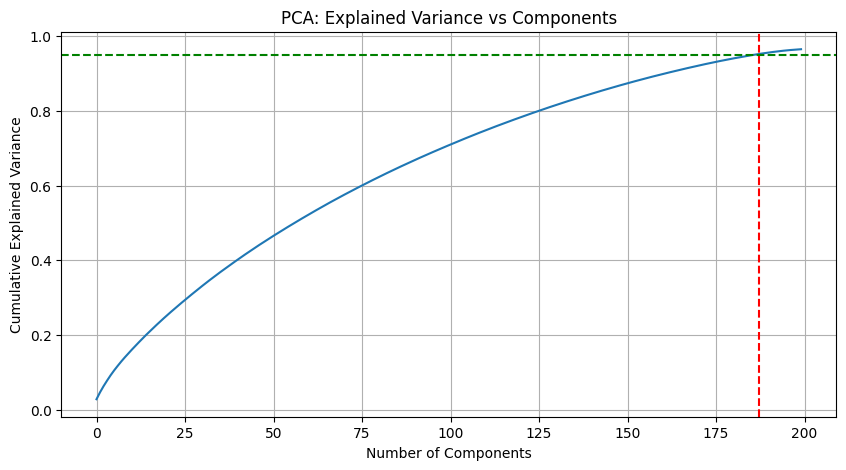

In [3]:
print("Applying PCA with dynamic component selection...")
# Select components to explain 95% of the variance
pca_full = PCA(random_state=42)
pca_full.fit(embeddings)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Components needed to explain 95% variance: {n_components_95}")

pca = PCA(n_components=n_components_95, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

print("Original shape:", embeddings.shape)
print("Reduced shape:", embeddings_pca.shape)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance[:200]) # Zoom in on first 200
plt.axvline(x=n_components_95, color='r', linestyle='--')
plt.axhline(y=0.95, color='g', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance vs Components")
plt.grid(True)
plt.show()

## 3.3 Silhouette Analysis (Finding Optimal K)

We test multiple cluster sizes and select the K with the highest silhouette score.

Calculating silhouette scores (cosine metric)...
K=2, Score: 0.0400
K=3, Score: 0.0351
K=4, Score: 0.0337
K=5, Score: 0.0328
K=6, Score: 0.0336
K=7, Score: 0.0351
K=8, Score: 0.0306
K=9, Score: 0.0317
K=10, Score: 0.0317

Optimal Number of Clusters (K): 2


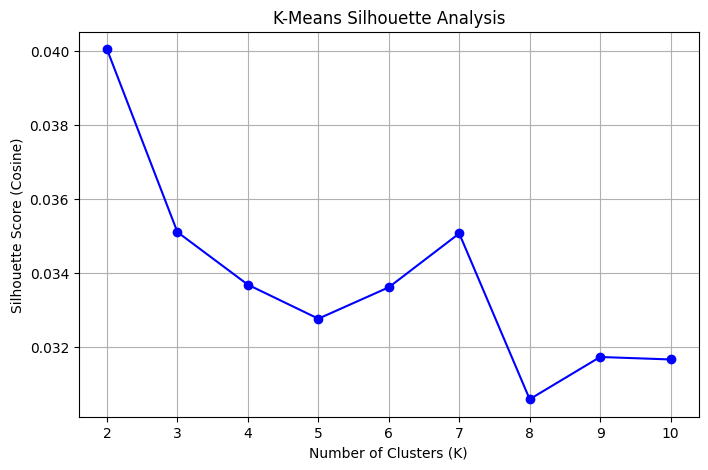

In [4]:
# Silhouette Analysis (Optimal K selection)

k_range = list(range(2, 11))
scores = []

print("Calculating silhouette scores (cosine metric)...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(embeddings_pca)
    score = silhouette_score(embeddings_pca, labels, metric='cosine')
    scores.append(score)
    print(f"K={k}, Score: {score:.4f}")

optimal_k = k_range[np.argmax(scores)]
print(f"\nOptimal Number of Clusters (K): {optimal_k}")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(k_range, scores, 'bo-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score (Cosine)")
plt.title("K-Means Silhouette Analysis")
plt.grid(True)
plt.show()

## 3.4 Interactive Visualization 
We use UMAP to project the 768-dimensional embeddings into 2D space.

C:\Users\rajga\anaconda3\envs\NLP\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


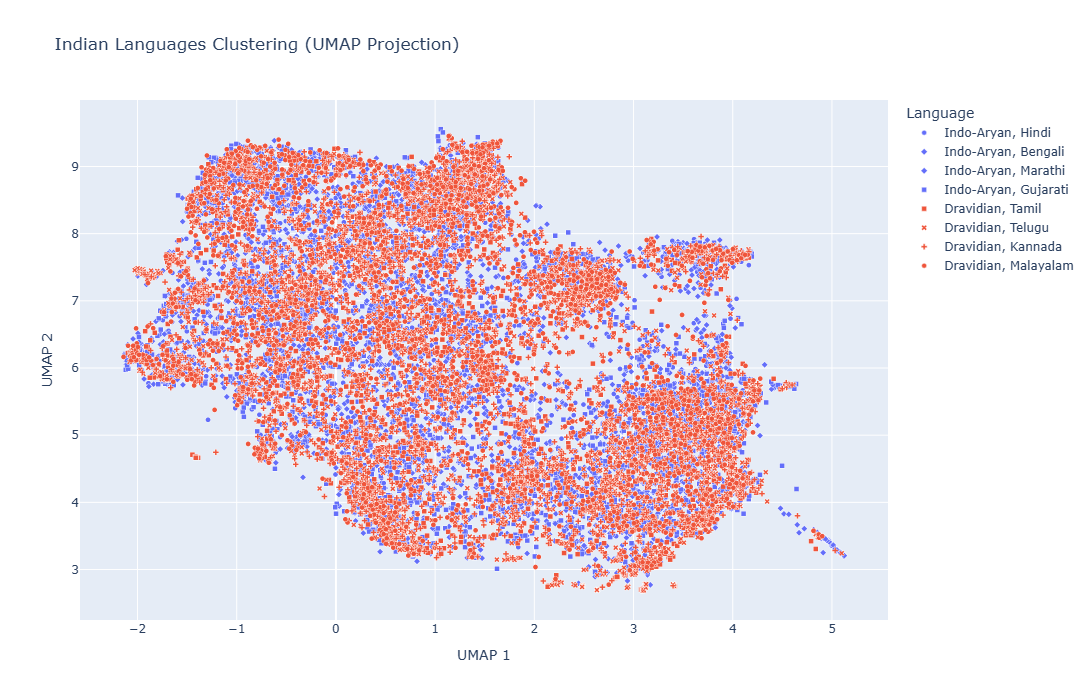

In [5]:
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.0,
    metric='cosine',
    random_state=42,
    low_memory=True
)
embeddings_2d = reducer.fit_transform(embeddings_pca)

# Vectorized assignment
df['x'] = embeddings_2d[:, 0]
df['y'] = embeddings_2d[:, 1]

# Interactive Plot
fig = px.scatter(
    df, 
    x='x', 
    y='y', 
    color='Family', 
    symbol='language', 
    title='Indian Languages Clustering (UMAP Projection)',
    hover_data=['language', 'Family', 'text'],
    template='plotly',
    width=1000,
    height=700
)

fig.update_traces(marker=dict(size=5, opacity=1, line=dict(width=0.5, color='white')))
fig.update_layout(
    legend_title_text='Language',
    xaxis_title='UMAP 1',
    yaxis_title='UMAP 2'
)
fig.show()

## 3.5 Misclassification Analysis (Vectorized)
We identifying languages that don't fit the expected Indo-Aryan vs Dravidian split (K=2).

In [6]:
# Fit K=2
kmeans_2 = KMeans( 
    n_clusters=2,
    init='k-means++',
    n_init=10,
    random_state=42)
df['cluster_id'] = kmeans_2.fit_predict(embeddings_pca)

# Map Clusters to Families vectorially
cluster_modes = df.groupby('cluster_id')['Family'].agg(lambda x: x.mode()[0])
df['predicted_family'] = df['cluster_id'].map(cluster_modes)

# Evaluation Metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(df['Family'], df['cluster_id'])
nmi = normalized_mutual_info_score(df['Family'], df['cluster_id'])

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Identify misclassifications
misclassified = df[df['Family'] != df['predicted_family']]
count = len(misclassified)
print(f"Total Misclassified Sentences: {count}")

# Display first few examples
if count > 0:
    display(misclassified[['language', 'Family', 'predicted_family', 'text']].head(10))

Adjusted Rand Index (ARI): 0.0002
Normalized Mutual Information (NMI): 0.0003
Total Misclassified Sentences: 7866


language      Family predicted_family  \
1     Hindi  Indo-Aryan        Dravidian   
3     Hindi  Indo-Aryan        Dravidian   
4     Hindi  Indo-Aryan        Dravidian   
5     Hindi  Indo-Aryan        Dravidian   
7     Hindi  Indo-Aryan        Dravidian   
8     Hindi  Indo-Aryan        Dravidian   
9     Hindi  Indo-Aryan        Dravidian   
10    Hindi  Indo-Aryan        Dravidian   
14    Hindi  Indo-Aryan        Dravidian   
15    Hindi  Indo-Aryan        Dravidian   

                                                 text  
1   इनेलो 1987 में उस वक्त ऐसे ही दोराहे पर खड़ी थ...  
3   इसके बाद केंद्र की ओर से प्रदेश सरकार को पीएमज...  
4   यह पूछने पर कि इस बड़े मैच से पहले उनकी नींद ग...  
5   समाचार एजेंसी 'डीपीए' के अनुसार, उप गृह मंत्री...  
7   बुधवार सुबह 10.30 बजे बड़ी संख्या में एबीवीपी क...  
8   बता दें कि ये फोटो ड्रग्स पैडलर द्वारा सैंपल क...  
9   विक्टोरिया: प्रधानमंत्री नरेंद्र मोदी ने आज कह...  
10  चीनी रक्षा मंत्रालय ने एक बयान जारी करके इसकी ...  
14  लैब से वायरस लीक होने के कई ऐसे मामले हैं जिनक...  
15  उसका चेक नंबर 36 दर्शाया जा रहा है। व्यापारी न...